In [1]:
# Load packages
import matplotlib.pyplot as plt
import numpy as np

CURRENT_DIR = os.getcwd()
PARENT_DIR = os.path.dirname(CURRENT_DIR)
sys.path.append(PARENT_DIR)

from FDApy.local_polynomial import LocalPolynomial

from sklearn.preprocessing import PolynomialFeatures

In [ ]:
def _gaussian(t):
    """Compute the gaussian density with mean 0 and stadard deviation 1.

    Parameters
    ----------
    t : array-like, shape = [n_samples]
        Array at which computes the gaussian density

    Return
    ------
    K : array-like, shape = [n_samples]
    """
    return np.exp(- t**2 / 2) / np.sqrt(2 * np.pi)

def _epanechnikov(t):
    """Compute the Epanechnikov kernel.

    Parameters
    ----------
    t : array-like, shape = [n_samples]
        Array on which computes the Epanechnikov kernel

    Return
    ------
    K : array-like, shape = [n_samples]

    References
    ----------
    Hastie, Tibshirani and Friedman, Elements of Statistical Learning, 2009,
    equation 6.4
    """
    K = np.zeros(t.shape)
    idx = np.where(np.abs(t) <= 1)
    K[idx] = 0.75 * (1 - t[idx]**2)
    return K

def _tri_cube(t):
    """Compute the tri-cube kernel.

    Parameters
    ----------
    t : array-like, shape = [n_samples]
        Array on which computes the tri-cube kernel

    Return
    ------
    K : array-like, shape = [n_samples]

    References
    ----------
    Hastie, Tibshirani and Friedman, Elements of Statistical Learning, 2009,
    equation 6.6
    """
    K = np.zeros(t.shape)
    idx = np.where(np.abs(t) < 1)
    K[idx] = (1 - np.abs(t[idx])**3)**3
    return K

def _bi_square(t):
    """Compute the bi-square kernel.

    Parameters
    ----------
    t : array-like, shape = [n_samples]
        Array on which computes the bi-square kernel

    Return
    ------
    K : array-like, shape = [n_samples]

    References
    ----------
    Cleveland, Robust Locally Weighted Regression and Smoothing Scatterplots,
    1979, p.831
    """
    K = np.zeros(t.shape)
    idx = np.where(np.abs(t) < 1)
    K[idx] = (1 - t[idx]**2)**2
    return K


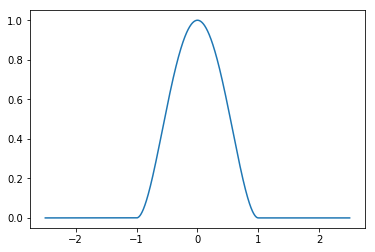

In [118]:
t = np.linspace(-2.5, 2.5, 1000)
plt.plot(t, _bi_square(t))

In [122]:
np.linalg.norm(t - 0.5, axis=0)

48.34774214828966

In [128]:
x0 = np.asarray([0.5])

In [123]:
np.sqrt(np.sum(np.power(t - 0.5, 2), axis=0))

48.34774214828966

In [129]:
np.sqrt(np.sum(np.power(t - x0[:, np.newaxis], 2), 0))

array([3.00000000e+00, 2.99499499e+00, 2.98998999e+00, 2.98498498e+00,
       2.97997998e+00, 2.97497497e+00, 2.96996997e+00, 2.96496496e+00,
       2.95995996e+00, 2.95495495e+00, 2.94994995e+00, 2.94494494e+00,
       2.93993994e+00, 2.93493493e+00, 2.92992993e+00, 2.92492492e+00,
       2.91991992e+00, 2.91491491e+00, 2.90990991e+00, 2.90490490e+00,
       2.89989990e+00, 2.89489489e+00, 2.88988989e+00, 2.88488488e+00,
       2.87987988e+00, 2.87487487e+00, 2.86986987e+00, 2.86486486e+00,
       2.85985986e+00, 2.85485485e+00, 2.84984985e+00, 2.84484484e+00,
       2.83983984e+00, 2.83483483e+00, 2.82982983e+00, 2.82482482e+00,
       2.81981982e+00, 2.81481481e+00, 2.80980981e+00, 2.80480480e+00,
       2.79979980e+00, 2.79479479e+00, 2.78978979e+00, 2.78478478e+00,
       2.77977978e+00, 2.77477477e+00, 2.76976977e+00, 2.76476476e+00,
       2.75975976e+00, 2.75475475e+00, 2.74974975e+00, 2.74474474e+00,
       2.73973974e+00, 2.73473473e+00, 2.72972973e+00, 2.72472472e+00,
      

In [117]:
def _compute_kernel(x, x0, h, kernel='gaussian'):
    """Compute kernel at point (x - x0) / h.

    Parameters
    ----------
    kernel : string, default='gaussian'
        Kernel name used.
    x : array-like, shape = [n_dim, n_samples]
        Training data.
    x0 : float-array, shape= [n_dim,]
        Number around which compute the kernel.
    h : float
        Bandwidth to control the importance of points far from x0.

    Return
    ------
    K : array-like , shape = [n_samples, n_samples]

    References
    ----------
    Hastie, Tibshirani and Friedman, Elements of Statistical Learning, 2009,
    equation 6.13
    """

    if not np.iterable(x0):
        x0 = np.asarray([x0])

    t = np.sqrt(np.sum(np.power(x - x0.T, 2), axis=0)) / h

    if kernel is 'gaussian':
        K = _gaussian(t)
    elif kernel is 'epanechnikov':
        K = _epanechnikov(t)
    elif kernel is 'tricube':
        K = _tri_cube(t)
    elif kernel is 'bisquare':
        K = _bi_square(t)
    else:
        raise ValueError(''.join[
            'The kernel `', kernel, '` is not implemented!'])

    return np.diag(K.flatten())

def _loc_poly(x, y, x0, B,
              kernel='gaussian', h=0.05, degree=2):
    """Local polynomial regression for one point.

    Let (x_1, Y_1), ...., (x_n, Y_n) be a random sample of bivariate data.
    Assume the following model: Y_i = f(x_i) + e_i. We would like to estimate
    the unknown regression function f(x) = E[Y | X = x]. We approximate f(x)
    using Taylor series.

    Parameters
    ----------
    x : array-like, shape = [n_samples]
        1-D input array.
    y : array-like, shape = [n_samples]
        1-D input array such that y = f(x) + e.
    x0 : float
        1-D array on which estimate the function f(x).
    B : array-like, shape = [n_sample, degree+1]
        Design matrix.
    kernel : string, default='gaussian'
        Kernel name used as weight.
    h : float, default=0.05
        Bandwidth for the kernel trick.
    degree : integer, default=2
        Degree of the local polynomial to fit.

    Return
    ------
    y0_pred : float
        Prediction of y0, which is f(x0).

    References
    ----------
    Zhang and Chen, Statistical Inferences for functional data, The Annals of
    Statistics, 1052-1079, No. 3, Vol. 35, 2007.

    """
    x0 = np.array([x0], ndmin=2)

    # Compute kernel.
    K = _compute_kernel(x=x, x0=x0, h=h, kernel=kernel)

    # Compute the estimation of f (and derivatives) at x0.
    BtW = np.dot(B.T, K)
    beta = np.dot(np.linalg.pinv(np.dot(BtW, B)), np.dot(BtW, y))

    poly_features = PolynomialFeatures(degree=degree)
    B0 = poly_features.fit_transform(x0)

    return np.dot(B0, beta)[0]

In [84]:
class LocalPolynomial():
    """Local polynomial regression.

    Let (x_1, Y_1), ...., (x_n, Y_n) be a random sample of bivariate data.
    For all i, x_i belongs to R^d and Y_i in R. Assume the following model:
    Y_i = f(x_i) + e_i. We would like to estimate the unknown regression

    function f(x) = E[Y | X = x]. We approximate f(x) using Taylor series.

    Parameters
    ----------
    kernel : string, default="gaussian"
        Kernel name used as weight (default = 'gaussian').
    bandwidth : float, default=0.05
        Strictly positive. Control the size of the associated neighborhood.
    degree: integer, default=2
        Degree of the local polynomial to fit. If degree = 0, we fit the local
        constant estimator (equivalent to the Nadaraya-Watson estimator). If
        degree = 1, we fit the local linear estimator.

    Return
    ------

    References
    ----------
    * Zhang and Chen, Statistical Inferences for functional data, The Annals of
    Statistics, 1052-1079, No. 3, Vol. 35, 2007.
    * https://github.com/arokem/lowess/blob/master/lowess/lowess.py

    """
    def __init__(self, kernel="gaussian", bandwidth=0.05, degree=2):
        # TODO: Add test on parameters.
        self.kernel = kernel
        self.bandwidth = bandwidth
        self.degree = degree
        self.poly_features = PolynomialFeatures(degree=degree)

    def fit(self, x, y):
        """Fit local polynomial regression.

        Parameters:
        -----------
        x : array-like, shape = [n_dim, n_samples]
            Training data, input array.
        y : array-like, shape = [n_samples, ]
            Target values, 1-D input array

        Return
        ------
        self : returns an instance of self.
        """
        # TODO: Add tests on the parameters.
        self.X = np.array(x, ndmin=2)
        self.Y = y

        x0 = np.unique(self.X, axis=1).squeeze()

        design_matrix = self.poly_features.fit_transform(self.X.T)

        self.X_fit_ = np.array([_loc_poly(x, y, i, design_matrix,
                                self.kernel, h, self.degree)
                                for (i, h) in zip(x0.T, self.bandwidth)])
        return self

    def predict(self, X):
        """ Predict using local polynomial regression.

        Parameters
        ----------
        X : array-like, shape = [n_samples]

        Return
        ------
        y_pred : array-like, shape = [n_samples]
            Return predicted values.
        """
        if type(X) in (int, float, np.int_, np.float_):
            X = [X]

        design_matrix = self.poly_features.fit_transform(self.X.T)

        y_pred = np.array([_loc_poly(self.X, self.Y, i, design_matrix,
                           self.kernel, h, self.degree)
                           for (i, h) in zip(X, self.bandwidth)])

        return y_pred

In [4]:
X = np.random.normal(0, 1, 100)
Y = 2 * np.sin(X) + np.random.normal(0, 0.25, 100)
Y_true = 2 * np.sin(np.linspace(-2, 2, 200))

In [11]:
B = PolynomialFeatures(degree=0).fit_transform(np.array(X, ndmin=2).T)

In [54]:
_loc_poly(X, Y, 0.5, B, 'epanechnikov', 0.05, 0)

1.1057405653630688

In [38]:
Y[np.where((X > 0.45) & (X < 0.55))]

array([1.26080766, 0.9718603 , 1.06276029, 1.07988203])

In [35]:
W = _compute_kernel(np.array([0.50447648, 0.47454149, 0.47329971, 0.48634175], ndmin=2), 0.5, 0.05, 'epanechnikov')

In [43]:
np.sum(np.dot(W, Y[np.where((X > 0.45) & (X < 0.55))]) / np.sum(np.diag(W)))

1.105740563404357

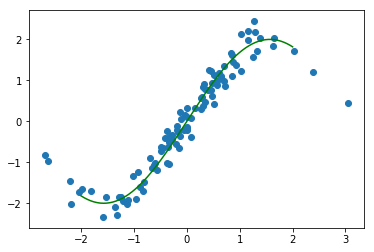

In [4]:
plt.scatter(X, Y)
plt.plot(np.linspace(-2, 2, 200), Y_true, 'green')
plt.show()

In [90]:
h_list = np.append(np.repeat(0.01, 50), np.repeat(0.2, 50))

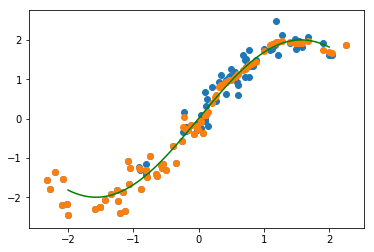

In [93]:
lp = LocalPolynomial(kernel="epanechnikov", bandwidth=h_list, degree=0)
lp.fit(X, Y)

plt.scatter(X, Y)
plt.scatter(np.sort(X), lp.predict(np.sort(X)))
plt.plot(np.linspace(-2, 2, 200), Y_true, 'green')
plt.show()